## **Load Data**##

In [1]:
import os
cwd = os.getcwd()

In [2]:
import pandas as pd

# read excel spreadsheet into a dataframe
raw = pd.read_excel(cwd + '/MAYO-01-17VW Client Data Tables and Stats Mouse Feces.xlsx', header=None, sheet_name=2, usecols="B, N:W", skiprows=lambda x: x in [0, 1, 2, 3, 4, 6])
raw.head()

,1,13,14,15,16,17,18,19,20,21,22
0,NaN,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12
1,(12 or 13)-methylmyristate (a15:0 or i15:0),0.546,1.7082,0.8329,0.8805,0.8143,1.5794,1.5593,0.76,1.1195,1.1442
2,(14 or 15)-methylpalmitate (a17:0 or i17:0),0.8032,1.0926,0.985,1.015,1.5243,1.3033,1.1455,0.8295,0.9563,0.9599
3,(16 or 17)-methylstearate (a19:0 or i19:0),0.8984,0.9141,0.8902,1.3977,1.8192,1.4932,1.4213,0.8549,0.8502,1.0859
4,(3'-5')-adenylyladenosine*,0.9026,0.3172,0.3172,0.3172,1.1893,1.834,1.0974,0.3172,0.8672,0.3172


In [3]:
def clean(df):
  """
  Processes the raw excel spreadsheet dataframe with pandas. Returns cleaned dataframe
  """
  # tranpose so axis 0 is the example dimension and axis 1 is the features dimension
  transposed = df.transpose()
  transposed.reset_index(drop=True, inplace=True)

  # use first row as header
  # https://stackoverflow.com/a/31328974/14772896
  new_header = transposed.iloc[0] #grab the first row for the header
  transposed = transposed[1:] #take the data less the header row
  transposed.columns = new_header #set the header row as the df header
  transposed.reset_index(drop=True, inplace=True)

  # Make a target column based on whether or not the sample was taken in Week 12
  transposed.insert(0, 'AfterProbiotic', transposed.iloc[:, 0] == 'Week 12', allow_duplicates=False)
  transposed = transposed.loc[:, transposed.columns.notnull()]
  transposed.index.name = None
  return transposed.apply(pd.to_numeric)

In [4]:
cleaned = clean(raw)
cleaned.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,False,0.5460,0.8032,0.8984,0.9026,0.5895,0.7820,0.6664,0.5189,0.9074,1.2116,0.5427,0.6067,0.7175,0.7145,4.6615,1.6053,1.6341,4.6839,0.2503,3.9389,2.0097,3.4388,2.3607,1.4496,1.7480,1.9858,1.5399,1.3928,2.6434,2.3116,3.2434,4.1724,4.1408,1.4611,1.3410,1.5991,0.9461,0.9943,0.6965,...,1.1918,1.6236,1.7702,1.2727,0.8276,1.9298,0.6983,0.2856,1.2941,2.0689,1.1117,3.8552,1.1622,1.2221,0.6737,2.0233,2.5518,0.3663,1.4431,0.6906,1.0781,0.7372,0.8385,0.8229,1.4471,1.4708,0.4072,0.8448,0.7833,1.8113,1.3575,1.3563,1.5313,1.0474,1.5043,1.5338,0.8068,0.9834,2.4123,1.4753
1,True,1.7082,1.0926,0.9141,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,0.6040,1.0262,0.4663,1.0000,1.0000,0.2503,1.0040,0.6730,0.6585,0.6235,1.1078,2.2458,1.2141,0.4362,0.0858,0.7279,1.1054,1.0840,1.0007,0.8398,1.0126,0.9336,0.7017,0.8449,1.4152,1.1351,...,0.2109,0.8326,0.4171,0.9422,1.7185,0.2752,0.7347,1.8993,0.8684,0.1221,0.9027,0.6520,0.2147,0.4120,1.2166,0.6022,0.3181,0.4783,0.7314,2.9701,0.4673,1.1139,0.9261,0.3800,0.0017,0.2868,0.1893,2.1602,0.7758,0.2236,0.6053,0.2418,0.3690,0.3287,0.4077,0.3621,1.0022,0.1372,0.7363,1.1754
2,False,0.8329,0.9850,0.8902,0.3172,0.5895,0.3336,0.3080,0.5189,0.5163,0.4368,0.5427,0.2938,0.4669,0.7560,2.3316,1.5337,0.8185,1.6029,0.2503,2.5860,0.9050,2.6298,1.1685,0.8655,0.8705,0.9987,1.0549,0.1557,1.3904,2.2538,2.6043,1.7533,1.9176,1.2990,0.9681,0.5809,0.5752,1.0057,0.9343,...,0.4894,1.0996,0.7747,1.0566,1.1663,1.2115,0.4887,0.3311,1.4079,1.0057,0.7584,3.3192,0.4822,0.5202,0.3360,1.0181,0.8959,0.1219,1.0160,0.6844,0.7175,0.9009,1.0247,0.5208,0.0017,1.0049,0.3182,1.0000,2.6314,0.7570,1.0206,0.6120,1.0378,0.6646,0.6428,0.8183,1.0019,0.6681,1.0300,1.3615
3,True,0.8805,1.0150,1.3977,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,1.3395,0.8934,0.4233,0.4953,0.4717,4.9623,0.5483,10.1152,0.3349,0.6235,2.2668,0.5827,2.1054,0.3546,0.0858,0.6017,0.6093,0.6119,0.7667

In [5]:
cleaned.describe()

,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,10-nonadecenoate (19:1n9),...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.094430,1.061460,1.162510,0.747650,0.836110,0.749780,0.70691,0.615120,0.963260,0.752160,0.715850,0.689710,0.897020,0.954700,1.560670,0.656840,0.850970,1.164440,0.871440,1.274110,2.05544,1.239940,0.872520,1.155080,1.073910,1.245110,0.961830,1.164970,1.012400,1.237910,1.299750,1.278570,1.505760,0.995730,1.146340,2.705680,1.177330,0.961310,1.045710,0.958790,...,0.966210,1.146730,1.008030,1.136780,1.322700,1.209420,1.322930,1.332920,1.263430,1.333350,0.967870,2.687780,0.978110,9.746190,1.402460,1.003110,1.258880,3.616560,1.028260,4.20269,1.203640,1.076310,1.200870,1.069410,0.973940,0.948680,0.766100,1.202880,1.218320,1.265750,0.999400,0.935250,1.031190,0.889050,0.877540,0.901970,1.231190,1.067430,1.400890,1.406120
std,0.399496,0.218739,0.344243,0.523054,0.432094,0.512219,0.49255,0.304274,0.735853,0.698268,0.412701,0.477522,0.619078,0.233998,1.225800,0.481497,0.371395,1.299997,1.483492,1.142181,2.90438,1.046124,0.551568,0.606409,0.567892,0.578464,0.482422,1.690005,0.649180,0.680115,0.910217,1.103139,1.187594,0.299437,0.341148,3.828121,0.674709,0.278823,0.279567,0.202727,...,0.622575,0.7318

In [41]:
import numpy as np
cleaned2 = cleaned.copy()
cleaned2['mouseID'] = (np.arange(len(cleaned2)) // 2) + 1
cleaned2['AfterProbiotic'] = cleaned2['AfterProbiotic'].astype(int)

In [216]:
cleaned2['isMale'] =  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
# cleaned2 = pd.get_dummies(cleaned2, columns=['mouseID'])
cleaned2

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose,mouseID,isMale
0,0,0.5460,0.8032,0.8984,0.9026,0.5895,0.7820,0.6664,0.5189,0.9074,1.2116,0.5427,0.6067,0.7175,0.7145,4.6615,1.6053,1.6341,4.6839,0.2503,3.9389,2.0097,3.4388,2.3607,1.4496,1.7480,1.9858,1.5399,1.3928,2.6434,2.3116,3.2434,4.1724,4.1408,1.4611,1.3410,1.5991,0.9461,0.9943,0.6965,...,1.7702,1.2727,0.8276,1.9298,0.6983,0.2856,1.2941,2.0689,1.1117,3.8552,1.1622,1.2221,0.6737,2.0233,2.5518,0.3663,1.4431,0.6906,1.0781,0.7372,0.8385,0.8229,1.4471,1.4708,0.4072,0.8448,0.7833,1.8113,1.3575,1.3563,1.5313,1.0474,1.5043,1.5338,0.8068,0.9834,2.4123,1.4753,1,1
1,1,1.7082,1.0926,0.9141,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,0.6040,1.0262,0.4663,1.0000,1.0000,0.2503,1.0040,0.6730,0.6585,0.6235,1.1078,2.2458,1.2141,0.4362,0.0858,0.7279,1.1054,1.0840,1.0007,0.8398,1.0126,0.9336,0.7017,0.8449,1.4152,1.1351,...,0.4171,0.9422,1.7185,0.2752,0.7347,1.8993,0.8684,0.1221,0.9027,0.6520,0.2147,0.4120,1.2166,0.6022,0.3181,0.4783,0.7314,2.9701,0.4673,1.1139,0.9261,0.3800,0.0017,0.2868,0.1893,2.1602,0.7758,0.2236,0.6053,0.2418,0.3690,0.3287,0.4077,0.3621,1.0022,0.1372,0.7363,1.1754,1,1
2,0,0.8329,0.9850,0.8902,0.3172,0.5895,0.3336,0.3080,0.5189,0.5163,0.4368,0.5427,0.2938,0.4669,0.7560,2.3316,1.5337,0.8185,1.6029,0.2503,2.5860,0.9050,2.6298,1.1685,0.8655,0.8705,0.9987,1.0549,0.1557,1.3904,2.2538,2.6043,1.7533,1.9176,1.2990,0.9681,0.5809,0.5752,1.0057,0.9343,...,0.7747,1.0566,1.1663,1.2115,0.4887,0.3311,1.4079,1.0057,0.7584,3.3192,0.4822,0.5202,0.3360,1.0181,0.8959,0.1219,1.0160,0.6844,0.7175,0.9009,1.0247,0.5208,0.0017,1.0049,0.3182,1.0000,2.6314,0.7570,1.0206,0.6120,1.0378,0.6646,0.6428,0.8183,1.0019,0.6681,1.0300,1.3615,2,1
3,1,0.8805,1.0150,1.3977,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,1.3395,0.8934,0.4233,0.4953,0.4717,4.9623,0.5483,10.1152,0.3349,0.6235,2.2668,0.5827,2.1054,0.3546,0.0858,0.6017,0.6093,0.6119,0.7667,2.6228,0.6417,1.5097,12.9486,1.0539,1.2131,1.238

## **PCA**##

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
components = pca.fit_transform(cleaned.iloc[:, 1:])
pcaDF = pd.DataFrame(data = components
             , columns = ['PC1', 'PC2', 'PC3'])
pcaDFPlot = pd.concat([pcaDF, cleaned['AfterProbiotic'].map({True : "Week 12", False : "Day 7"})], axis=1)
pcaDFPlot

,PC1,PC2,PC3,AfterProbiotic
0,17.799388,59.013447,35.320696,Day 7
1,-9.423772,6.763368,-18.992523,Week 12
2,-7.105651,6.705818,-16.782658,Day 7
3,-18.569043,6.063026,-23.818238,Week 12
4,2.732120,0.349566,-12.392016,Day 7
5,-9.019857,5.189297,-20.646959,Week 12
6,-15.491500,-4.673054,-0.547104,Day 7
7,39.051047,-26.047919,1.975415,Week 12
8,-52.798173,-28.243471,43.165156,Day 7
9,52.825442,-25.120077,12.718231,Week 12


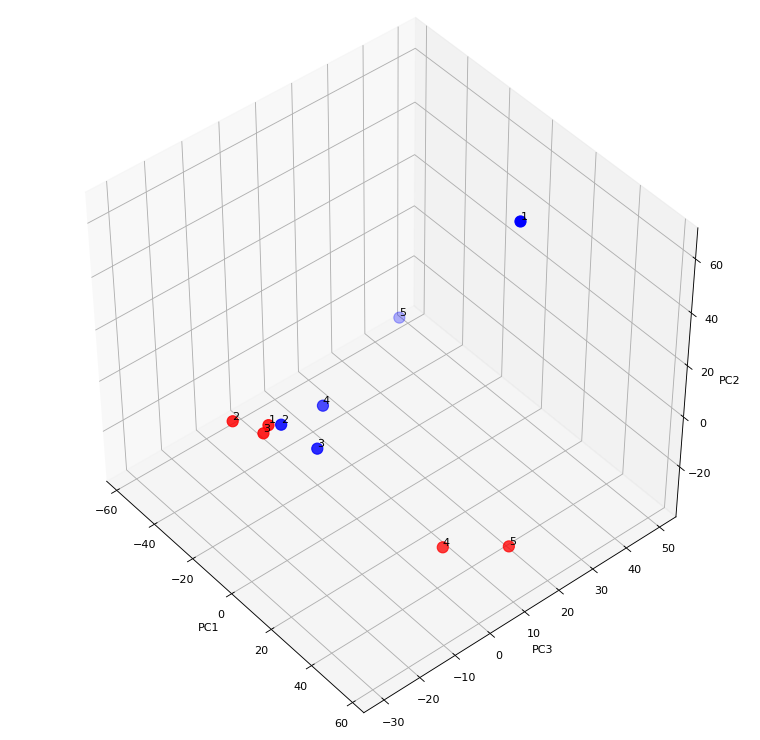

In [10]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pylab

fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(projection='3d')


col = np.where(cleaned['AfterProbiotic'],'r', 'b')
ax.scatter(xs=pcaDF['PC1'], ys=pcaDF['PC3'], zs=pcaDF['PC2'], c=col, s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC3')
ax.set_zlabel('PC2')
ax.set_zlim(min(pcaDF['PC2']) - 10, max(pcaDF['PC2']) + 10)
ax.set_xlim(min(pcaDF['PC1']) - 10, max(pcaDF['PC1']) + 10)
ax.set_ylim(min(pcaDF['PC3']) - 10, max(pcaDF['PC3']) + 10)

# set view angle
ax.view_init(elev=45., azim=320)


# label samples

xs=pcaDF['PC1']
ys=pcaDF['PC3']
zs=pcaDF['PC2']

for i in range(10):
    label = i // 2 + 1
    ax.text(xs[i], ys[i], zs[i] + 1, label)

In [11]:
components

array([[ 17.79938755,  59.01344718,  35.32069646],
       [ -9.42377236,   6.76336784, -18.9925232 ],
       [ -7.10565099,   6.70581753, -16.78265758],
       [-18.56904293,   6.06302565, -23.81823842],
       [  2.73212022,   0.34956589, -12.39201622],
       [ -9.01985682,   5.18929686, -20.6469587 ],
       [-15.49149988,  -4.67305375,  -0.54710391],
       [ 39.05104672, -26.04791919,   1.97541452],
       [-52.79817319, -28.24347148,  43.16515569],
       [ 52.82544168, -25.12007654,  12.71823135]])

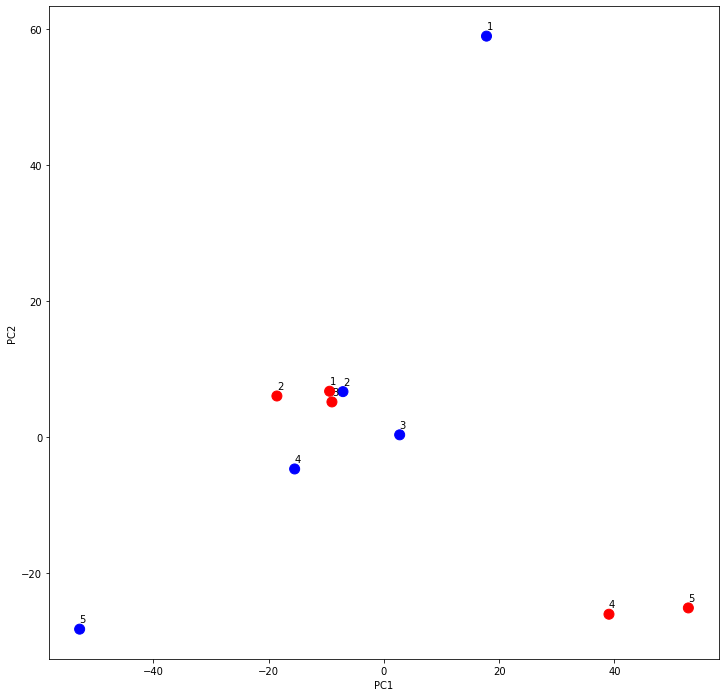

In [12]:
plt.figure(figsize=(12,12))
plt.scatter(components[:,0],components[:,1],c=col, s=100)
plt.xlabel('PC1')
plt.ylabel('PC2')
for i in range(10):
    label = i // 2 + 1
    plt.text(xs[i], zs[i] + 1, label)

## **Wilcoxon Signed-Rank Test**##

In [13]:
X_before = cleaned.iloc[np.arange(0, 10, 2), 1:]
X_after = cleaned.iloc[np.arange(1, 10, 2), 1:]
X_before.shape, X_after.shape

((5, 823), (5, 823))

In [14]:
X_before

,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,10-nonadecenoate (19:1n9),...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0.5460,0.8032,0.8984,0.9026,0.5895,0.7820,0.6664,0.5189,0.9074,1.2116,0.5427,0.6067,0.7175,0.7145,4.6615,1.6053,1.6341,4.6839,0.2503,3.9389,2.0097,3.4388,2.3607,1.4496,1.7480,1.9858,1.5399,1.3928,2.6434,2.3116,3.2434,4.1724,4.1408,1.4611,1.3410,1.5991,0.9461,0.9943,0.6965,1.0047,...,1.1918,1.6236,1.7702,1.2727,0.8276,1.9298,0.6983,0.2856,1.2941,2.0689,1.1117,3.8552,1.1622,1.2221,0.6737,2.0233,2.5518,0.3663,1.4431,0.6906,1.0781,0.7372,0.8385,0.8229,1.4471,1.4708,0.4072,0.8448,0.7833,1.8113,1.3575,1.3563,1.5313,1.0474,1.5043,1.5338,0.8068,0.9834,2.4123,1.4753
2,0.8329,0.9850,0.8902,0.3172,0.5895,0.3336,0.3080,0.5189,0.5163,0.4368,0.5427,0.2938,0.4669,0.7560,2.3316,1.5337,0.8185,1.6029,0.2503,2.5860,0.9050,2.6298,1.1685,0.8655,0.8705,0.9987,1.0549,0.1557,1.3904,2.2538,2.6043,1.7533,1.9176,1.2990,0.9681,0.5809,0.5752,1.0057,0.9343,0.9953,...,0.4894,1.0996,0.7747,1.0566,1.1663,1.2115,0.4887,0.3311,1.4079,1.0057,0.7584,3.3192,0.4822,0.5202,0.3360,1.0181,0.8959,0.1219,1.0160,0.6844,0.7175,0.9009,1.0247,0.5208,0.0017,1.0049,0.3182,1.0000,2.6314,0.7570,1.0206,0.6120,1.0378,0.6646,0.6428,0.8183,1.0019,0.6681,1.0300,1.3615
4,0.8143,1.5243,1.8192,1.1893,1.8177,1.2323,1.5371,0.5189,1.9749,1.9684,1.0000,1.3563,1.6679,1.0104,0.8923,0.4233,0.4953,0.4717,0.2503,0.7418,0.7356,0.3349,0.6235,0.6912,0.5827,0.6497,1.8508,1.0000,1.3181,1.9758,1.3481,1.2345,0.9904,0.9874,1.8818,0.8571,1.3409,1.0539,0.8757,1.2342,...,1.8919,0.9004,1.7224,0.8730,0.4832,4.1224,3.4778,0.5064,0.9965,3.7900,0.8103,0.4081,1.7345,1.0666,0.8690,1.0744,3.0412,0.3709,1.0633,0.6363,2.2233,0.9106,0.9753,1.1771,1.0000,1.6988,1.6426,1.0000,2.3941,3.1705,1.0112,1.9718,1.8041,1.6986,1.5167,1.3861,0.7884,1.0166,3.3436,0.3555
6,1.5593,1.1455,1.4213,1.0974,1.0000,1.0149,0.7332,0.5189,1.0926,0.7884,0.5427,1.1084,1.1504,1.0780,0.7440,0.4233,0.4953,0.4717,0.5890,0.3862,1.5231,0.6222,0.6235,1.1883,1.4487,0.9700,1.0898,0.2625,0.6017,0.5429,0.39

In [15]:
X_after

,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,10-nonadecenoate (19:1n9),...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
1,1.7082,1.0926,0.9141,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,0.6040,1.0262,0.4663,1.0000,1.0000,0.2503,1.0040,0.6730,0.6585,0.6235,1.1078,2.2458,1.2141,0.4362,0.0858,0.7279,1.1054,1.0840,1.0007,0.8398,1.0126,0.9336,0.7017,0.8449,1.4152,1.1351,1.0875,...,0.2109,0.8326,0.4171,0.9422,1.7185,0.2752,0.7347,1.8993,0.8684,0.1221,0.9027,0.6520,0.2147,0.4120,1.2166,0.6022,0.3181,0.4783,0.7314,2.9701,0.4673,1.1139,0.9261,0.3800,0.0017,0.2868,0.1893,2.1602,0.7758,0.2236,0.6053,0.2418,0.3690,0.3287,0.4077,0.3621,1.0022,0.1372,0.7363,1.1754
3,0.8805,1.0150,1.3977,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,1.3395,0.8934,0.4233,0.4953,0.4717,4.9623,0.5483,10.1152,0.3349,0.6235,2.2668,0.5827,2.1054,0.3546,0.0858,0.6017,0.6093,0.6119,0.7667,2.6228,0.6417,1.5097,12.9486,1.0539,1.2131,1.2385,0.6501,...,0.2568,1.1114,0.2424,1.7472,2.7383,0.0998,0.2169,0.9625,0.9641,0.3407,0.3137,0.3702,0.2327,0.4701,2.6370,0.5118,0.1441,3.6719,0.7135,26.9003,0.1738,2.0386,1.5402,0.3162,0.0017,0.5077,0.1893,2.1036,1.5083,0.1359,0.6317,0.1877,0.3173,0.1652,0.4077,0.1959,1.9466,1.8837,0.5316,1.1081
5,1.5794,1.3033,1.4932,1.8340,1.3701,1.8155,1.2668,1.4811,1.8791,1.8954,1.8169,1.4651,2.2503,0.7696,2.0064,0.4233,0.9593,1.2819,1.4110,1.2740,2.4295,1.0000,0.8315,2.0482,1.0266,2.0246,0.4315,0.0858,0.6374,0.9127,0.8258,1.2757,2.0552,0.8310,0.9715,4.5214,0.5614,1.2129,1.4596,1.1697,...,0.3742,0.4652,0.4976,0.9434,0.5957,0.4390,1.2653,1.0375,1.0035,0.3390,0.6862,0.2923,0.3888,1.1876,0.4744,0.4758,0.4536,1.0531,0.5824,4.6709,1.6543,1.0894,0.5784,0.6827,0.0017,1.0552,2.0811,0.9235,1.5337,0.2690,0.4767,0.2795,0.3617,0.3689,0.4077,0.3412,0.7529,1.7347,0.9700,0.2827
7,0.7600,0.8295,0.8549,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,1.1492,0.9738,0.4233,1.0344,0.4922,0.2503,0.9960,0.5888,1.5874,0.6235,0.6001,0.9734,0.9446,1.0533,3.9954,1.0000,0.8554,0

In [16]:
import scipy
from math import inf

wilcoxon = pd.DataFrame(columns=['W_stat', 'p-value'])

# For each biochemical, perform the Wilcoxon Signed-Rank Test on the two classes: before and after probiotic. 
# Store values in wilcoxon
for biochem in range(823):
  X_before_biochem = X_before.iloc[:, biochem]
  X_after_biochem = X_after.iloc[:, biochem]
  # don't apply the test if the values are equal
  if (X_before_biochem.values == X_after_biochem.values).all():
    wilcoxon = wilcoxon.append({'W_stat' : inf, 'p-value' : 1.0}, ignore_index=True)
    continue
  result = scipy.stats.wilcoxon(X_before_biochem, X_after_biochem)
  wilcoxon = wilcoxon.append({'W_stat' : result.statistic, 'p-value' : result.pvalue}, ignore_index=True)
wilcoxon

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,W_stat,p-value
0,4.0,0.345231
1,7.0,0.892738
2,7.0,0.892738
3,3.0,0.465209
4,0.0,0.108809
...,...,...
818,3.0,0.224916
819,6.0,0.685830
820,7.0,0.892738
821,0.0,0.043114


In [17]:
# print the biochemicals with p_value < 0.05 
crit = wilcoxon.loc[wilcoxon['p-value'] < 0.05]
crit

,W_stat,p-value
26,0.0,0.043114
37,0.0,0.043114
44,0.0,0.043114
45,0.0,0.043114
54,0.0,0.043114
...,...,...
811,0.0,0.043114
813,0.0,0.043114
815,0.0,0.043114
821,0.0,0.043114


<h1>Benjamini-Hochberg Multiple Hypothesis Correction</h1>

In [18]:
def BenjaminiHochberg(p_vals):
  """Returns p_vals after applying multiple hypothesis correction  
  using the Benjamini-Hochberg procedure"""
  ret = p_vals.copy()
  sorted_idx = np.argsort(p_vals)
  s = sorted(p_vals)
  last = s[-1]
  for i in range(len(p_vals) - 1, -1, -1):
    idx = sorted_idx[i]
    ret[idx] = min(last, s[i] * len(p_vals) / (i + 1))
    last = ret[idx]
    ret[idx] = round(ret[idx], 6)
  return ret

In [19]:
p_vals = wilcoxon['p-value'].to_numpy(copy=True)
p_vals[:10]

array([0.34523107, 0.8927384 , 0.8927384 , 0.46520882, 0.10880943,
       0.27332168, 0.71500065, 0.31731051, 0.50018426, 0.06788915])

In [20]:
p_vals_corrected = BenjaminiHochberg(p_vals)
p_vals_corrected[:10]

array([0.627208, 0.903719, 0.903719, 0.723465, 0.401353, 0.598255,
       0.831138, 0.627208, 0.723465, 0.304762])

In [21]:
wilcoxon['p-value'] = p_vals_corrected
wilcoxon

,W_stat,p-value
0,4.0,0.627208
1,7.0,0.903719
2,7.0,0.903719
3,3.0,0.723465
4,0.0,0.401353
...,...,...
818,3.0,0.504375
819,6.0,0.806341
820,7.0,0.903719
821,0.0,0.275063


In [22]:
wilcoxon.nsmallest(10, 'p-value')

,W_stat,p-value
26,0.0,0.275063
37,0.0,0.275063
44,0.0,0.275063
45,0.0,0.275063
54,0.0,0.275063
75,0.0,0.275063
80,0.0,0.275063
86,0.0,0.275063
87,0.0,0.275063
95,0.0,0.275063


There are no significant p-values after multiple hypothesis correction

##**Hierarchical Clustering**##

In [23]:
cluster_df = cleaned.iloc[:, 1:].T
cluster_df.rename(mapper=(lambda x : str(x // 2 + 1) + ("_12" if x % 2 == 1 else "_7")), inplace=True, axis=1)
# cluster_df = cluster_df[cluster_df.columns[::-1]]
cluster_df

,1_7,1_12,2_7,2_12,3_7,3_12,4_7,4_12,5_7,5_12
0,,,,,,,,,,
(12 or 13)-methylmyristate (a15:0 or i15:0),0.5460,1.7082,0.8329,0.8805,0.8143,1.5794,1.5593,0.7600,1.1195,1.1442
(14 or 15)-methylpalmitate (a17:0 or i17:0),0.8032,1.0926,0.9850,1.0150,1.5243,1.3033,1.1455,0.8295,0.9563,0.9599
(16 or 17)-methylstearate (a19:0 or i19:0),0.8984,0.9141,0.8902,1.3977,1.8192,1.4932,1.4213,0.8549,0.8502,1.0859
(3'-5')-adenylyladenosine*,0.9026,0.3172,0.3172,0.3172,1.1893,1.8340,1.0974,0.3172,0.8672,0.3172
(3'-5')-adenylylcytidine,0.5895,0.5895,0.5895,0.5895,1.8177,1.3701,1.0000,0.5895,0.6363,0.5895
...,...,...,...,...,...,...,...,...,...,...
vanillate,1.5338,0.3621,0.8183,0.1959,1.3861,0.3412,1.0314,1.0589,0.9686,1.3234
xanthine,0.8068,1.0022,1.0019,1.9466,0.7884,0.7529,1.9159,0.9981,2.6993,0.3998
xanthosine,0.9834,0.1372,0.6681,1.8837,1.0166,1.7347,1.9627,0.4410,0.7245,1.1224


In [24]:
import seaborn as snb
methods = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
# fig = plt.figure()
# for method in methods:
#   if method in ['cosine', 'correlation', 'jensenshannon', 'mahalanobis', 'yule', 'seuclidean']:
#     continue
#   print(method)
#   snb.clustermap(cluster_df, robust=True, cmap="coolwarm", col_colors=5*[(0, 0.49, 0.71, 0.5), (1, 0.65, 0)], metric=method, z_score=1)
#   plt.show()

<Figure size 432x288 with 0 Axes>

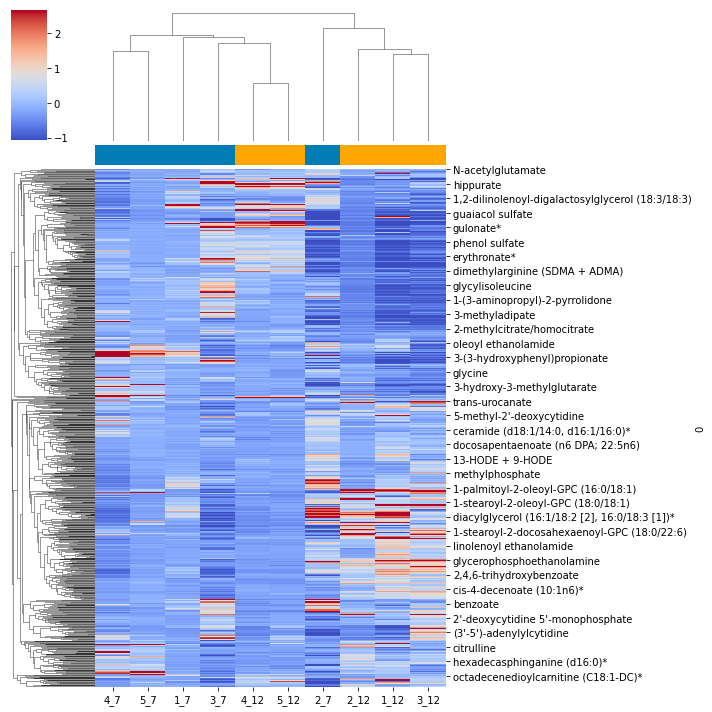

In [25]:
fig = plt.figure()
ax = snb.clustermap(cluster_df, robust=True, cmap="coolwarm", col_colors=5*[(0, 0.49, 0.71, 0.5), (1, 0.65, 0)], metric='canberra', z_score=1)
plt.show()

##**Linear Model**##

For each biochemical, create a mixed effects linear model with mouseID as a random effect and gender and abundance as a fixed effect

In [129]:
! mkdir data

In [157]:
for column in range(1, 824):
  df = cleaned2.iloc[:, [0, column, 824, 825]].copy()
  # change name of the biochem column to abundance
  df['abundance'] = df[df.columns[1]]
  df = df.drop(columns=[df.columns[1]])
  df.to_csv(cwd + "/data/%d.txt" % (column))

In [55]:
%load_ext rpy2.ipython

In [ ]:
%%R

install.packages("lme4",
   repos=c("http://lme4.r-forge.r-project.org/repos",
      getOption("repos")[["CRAN"]]))

library(lme4)

In [78]:
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [178]:
%%R
p_vals = data.frame(
   p_val = c(1:823)
)
head(p_vals)

  p_val
1     1
2     2
3     3
4     4
5     5
6     6


In [195]:
%%R

get_p_val = function(data) {
    model = glmer(AfterProbiotic ~ (1|mouseID) + abundance + isMale, data=data, family=binomial)
    coef = coef(summary(model))[,4]
    p_val = coef[2]
    return (p_val)
}

In [ ]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val = tryCatch(
      get_p_val(data),
      error=function(e) {return (1)}
  )
  p_vals[id, 1] = p_val
}

In [197]:
%%R
head(p_vals)

      p_val
1 0.3314071
2 0.7293395
3 0.8931477
4 0.4247669
5 0.4821257
6 0.4429726


In [198]:
%%R
write.csv(p_vals, "p_vals.csv")

In [201]:
p_vals = pd.read_csv("p_vals.csv")
p_vals

,Unnamed: 0,p_val
0,1,0.331407
1,2,0.729339
2,3,0.893148
3,4,0.424767
4,5,0.482126
...,...,...
818,819,0.148846
819,820,0.322706
820,821,0.984431
821,822,1.000000


In [203]:
p_vals.loc[p_vals['p_val'] < 0.05]

,Unnamed: 0,p_val
231,232,0.009317
292,293,0.049303


Two biochemicals have raw p values below 0.05

In [217]:
p_vals_numpy = p_vals.iloc[:, 1].to_numpy(copy=False)
p_vals_numpy = BenjaminiHochberg(p_vals_numpy)
p_vals_corrected = p_vals.copy()
p_vals_corrected.iloc[:, 1] = p_vals_numpy

In [215]:
p_vals_corrected.nsmallest(10, 'p_val')

,Unnamed: 0,p_val
23,24,0.750384
25,26,0.750384
26,27,0.750384
27,28,0.750384
28,29,0.750384
29,30,0.750384
30,31,0.750384
38,39,0.750384
42,43,0.750384
43,44,0.750384


There are no significant p values after correction